In [10]:
!pip install numpy pandas psychro
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/19/e5/a4ea514515f270224435c69359abb7a3d152ed31b9ee3ba5e63017461945/matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/58/56/e2c43dcfa1f9c7db4d5e3d6f5134b24ed953f4e2133a4b12f0062148db58/contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/e8/68/af41b7cfd35c7418e17b6a43bb106be4b0f0e5feb405a88dee29b186f2a7/fonttools-4.47.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
"""
Created on Sun Nov 12 20:46:15 2023

@author: Basia

Inputs:
θo, φo      outdoor temperature & humidity ratio
θ3, φ3      indoor temperature & humidity ratio set points
mi          infiltration mass flow rate
Qsaux, Qlaux    auxiliary sensible and latent loads [kW]
Qscab, Qlcab    heat generated by cabinets [kW]

Parameters:
m           mass flow rate of dry air
mo          outdoor mass flow rate as an input
β           by-pass factir od cooling coil
UA          overall heat transfer coefficient

Elements (13 equations):
MX1         mixing box (2 equations)
CC          cooling coil (3 equations)
MX2         mixing process (2 equations)
HC          heating coil (2 equations)
TZ          thermal zone (2 equations)
Kθ          indoor temperature controller (1 equation)
Kw          indoor humidity controller (1 equation)

Outputs (13 unknowns):
0, ..., 4     temperature and humidity ratio (10 unknowns)
Qt, Qsc, Qlc  (total), sensible and latent heat of CC (3 unknowns)
Qsh           sensible heat of HC (1 unknown)


"""

import numpy as np
import pandas as pd
import psychro as psy


# constants
c = 1e3         # J/kg K, air specific heat
l = 2496e3      # J/kg, latent heat

# to be used in self.m_ls / least_squares
m_max = 100     # ks/s, max dry air mass flow rate
θs_0 = 5        # °C, initial guess for saturation temperature

class MxCcRhTzBl:
    """
    **HVAC composition**:
        mixing, cooling with dehumidification, heating, thermal zone of the building -sales room
        
    """

    def __init__(self, parameters, inputs):
        m, mo, β, Kθ, Kw = parameters
        θo, φo, θ3, w3, θIsp, φIsp, mi, UA, Qsaux, Qlaux, Qscab, Qlcab = inputs

        self.design = np.array([m, mo, β, Kθ, Kw,       # parameters
                                θo, φo, θ3, w3, θIsp, φIsp,     # inputs air out, in
                                mi, UA, Qsaux, Qlaux, 
                                Qscab, Qlcab])      # --"--  building
        self.actual = np.array([m, mo, β, Kθ, Kw,
                                θo, φo, θ3, w3, θIsp, φIsp,
                                mi, UA, Qsaux, Qlaux, 
                                Qscab, Qlcab])

    def lin_model(self, θs0):
        """
        Linearized model.
            Solves a set of 16 linear equations.
            Saturation curve is linearized in θs0.

        s-point (θs, ws):

        - is on a tangent to φ = 100 % in θs0;

        - is **not** on the saturation curve (Apparatus Dew Point ADP).


        Parameter from function call
        ----------------------------
        θs0     °C, temperature for which the saturation curve is liniarized

        Parameters from object
        ---------------------
        m, mo, θo, φo, θ3, w3, θIsp, φIsp, β, mi, UA, Qsaux, Qlaux, 
        Qscab, Qlcab, Kθ, Kw = self.actual

        Equations (13)
        -------------
        +-------------+-----+----+-----+----+----+----+----+----+
        | Element     | MX1 | CC/DEHUM | MIX2 | HC | TZ | Kθ | Kw |
        +=============+=====+====+=====+====+====+====+====+====+
        | N° equations|  2  |   3     |  2   |  2  | 2 | 1  |  1 |
        +-------------+-----+----+-----+----+----+----+----+----+

        Returns (13 unknowns)
        ---------------------
        x : θ1, w1, θ2, w2, θ3, w3, θ4, w4, θ5, w5,
            Qsc, Qlc, Qsh,
        """
        """
        <=4================================m==========================
               ||                                                   ||
               4 (m-mo) =======0=======                             ||
               ||       ||  (1-β)m   ||                             ||
       θo,φo=>[MX1]==0==||          [MX2]==2==[HC]==F==3==>[TZ]==4==||
         mo             ||           ||        /   /       //       |
                        ===0=[CC]==1===       s   m       sl        |
                             /\\   βm         |           ||        |
                            t  sl             |          [BL]<-mi   |
                            |                 |          //         |
                            |                 |         sl          |
                            |                 |                     |
                            |                 |<------[K]-----------+<-wI
                            |<------------------------[K]-----------+<-θI
            """
        m, mo, β, Kθ, Kw, θo, φo, θ3, w3, θIsp, φIsp, mi, UA, Qsaux, Qlaux, Qscab, Qlcab = self.actual
        wo = psy.w(θo, φo)      # hum. out

        A = np.zeros((13, 13))  # coefficents of unknowns
        b = np.zeros(13)        # vector of inputs
        #MIX
        A[0,6], A[0,0], b[0] = (m-mo) * c, -m * c, -mo * c * θo
        A[1,7], A[1,1], b[1] = (m-mo) * l, -m * l, -mo * l * wo
        #CC Dehumidification
        A[2,0], A[2,10], A[2,8], b[2] = (1 - β) * m * c, -1, -(1 - β) * m * c, 0
        A[3,1], A[3,11], A[3,9], b[3] = (1 - β) * m * l, -1, -(1 - β) * m * l, 0  
        A[4,9], A[4,8], b[4] = 1, -psy.wsp(θs0), psy.w(θs0, 1) - psy.wsp(θs0) * θs0
        #MIX2
        A[5,0], A[5,8], A[5,2], b[5] = β * m * c, (1 - β) * m * c, -m * c, 0
        A[6,1], A[6,9], A[6,3], b[6] = β * m * l, (1 - β) * m * l, -m * l, 0  
        #Heating
        A[7,2], A[7,12], A[7,4], b[7] = m * c, 1, -m * c, 0
        A[8,3], A[8,5], b[8] = m * l, -m * l, 0
        #TZ & Sales Room
        A[9,4], A[9,6], b[9] = m * c, -(m * c + mi * c + UA), -Qscab - Qsaux - (mi * c + UA) * θo
        A[10,5], A[10,7], b[10] = m * l, -(m * l + mi * l), -mi * l * wo - Qlcab - Qlaux
        #Controller ????????
        A[11,4], A[11, 11], b[11] = Kθ, 1, Kθ * θIsp
        A[12,5], A[12, 10], b[12] = Kw, 1, Kw * psy.w(θIsp, φIsp)
        x = np.linalg.solve(A, b)
        return x
    
        
    def solve_lin(self, θs0):
        """
        Finds saturation point on saturation curve ws = f(θs).
            Solves iterativelly *lin_model(θs0)*:
            θs -> θs0 until ws = psy(θs, 1).

        Parameters
        ----------
        θs0     initial guess saturation temperature

        Method from object
        ---------------------
        *self.lin_model(θs0)*

        Returns (13 unknowns)
        ---------------------
        x of *self.lin_model(self, θs0)*
        """
        #linearization of saturation points
        Δ_ws = 10e-3  # kg/kg, initial difference to start the iterations
        while Δ_ws > 0.01e-3:
            x = self.lin_model(θs0)
            Δ_ws = abs(psy.w(x[8], 1) - x[9])   # psy.w(θs, 1) = ws
            θs0 = x[8]                          # actualize θs0
        return x

# mass flow rate optimization
    def m_ls(self, value, sp):
        """
        Mass flow rate m controls supply temperature θS or indoor humidity wI.
            Finds m which solves value = sp, i.e. minimizes ε = value - sp.
            Uses *scipy.optimize.least_squares* to solve the non-linear system.

        Parameters
        ----------
        value   string: 'θS' od 'wI' type of controlled variable
        sp      float: value of setpoint
#decimal numbers for set point eg. 21.65
        Calls
        -----
        *ε(m)*  gives (value - sp) to be minimized for m

        Returns (13 unknowns)
        ---------------------
        x           given by *self.lin_model(self, θs0)*
        """
        from scipy.optimize import least_squares

        def ε(m):
            """
            Gives difference ε = (values - sp) function of m
                ε  calculated by self.solve_lin(ts0)
                m   bounds=(0, m_max); m_max hard coded (global variable)

            Parameters
            ----------
            m : mass flow rate of dry air

            From object
                Method: self.solve.lin(θs0)
                Variables: self.actual <- m (used in self.solve.lin)
            Returns
            -------
            ε = value - sp: difference between value and its set point
            """
            self.actual[0] = m
            x = self.solve_lin(θs_0)
            if value == 'θS':
                θS = x[4]       # supply air
                return abs(sp - θS)
            elif value == 'φI':
                wI = x[5]       # indoor air
                return abs(sp - wI)
            else:
                print('ERROR in ε(m): value not in {"θS", "wI"}')

        m0 = self.actual[0]     # initial guess
        if value == 'φI':
            self.actual[4] = 0  #5 first values to 0
            sp = psy.w(self.actual[7], sp)
        # gives m for min(θSsp - θS); θs_0 is the initial guess of θs
        res = least_squares(ε, m0, bounds=(0, m_max))

        if res.cost < 0.1e-3:
            m = float(res.x)
            # print(f'm = {m: 5.3f} kg/s')
        else:
            print('RecAirVAV: No solution for m')

        self.actual[0] = m

        x = self.solve_lin(θs_0)
        return x

    def β_ls(self, value, sp):
        """
        Bypass β controls supply temperature θS or indoor humidity wI.
            Finds β which solves value = sp, i.e. minimizes ε = value - sp.
            Uses *scipy.optimize.least_squares* to solve the non-linear system.

        Parameters
        ----------
        value   string: 'θS' od 'wI' type of controlled variable
        sp      float: value of setpoint

        Calls
        -----
        *ε(m)*  gives (value - sp) to be minimized for m

        Returns (13 unknowns)
        ---------------------
        x           given by *self.lin_model(self, θs0)*
        """
        from scipy.optimize import least_squares

        def ε(β):
            """
            Gives difference ε = (values - sp) function of β
                ε  calculated by self.solve_lin(ts0)
                β   bounds=(0, 1)

            Parameters
            ----------
            β : by-pass factor of the cooling coil

            From object
                Method: self.solve.lin(θs0)
                Variables: self.actual <- m (used in self.solve.lin)
            Returns
            -------
            ε = value - sp: difference between value and its set point
            """
            self.actual[2] = β
            x = self.solve_lin(θs_0)
            if value == 'θS':
                θS = x[4]       # supply air
                return abs(sp - θS)
            elif value == 'φI':
                wI = x[5]       # indoor air
                return abs(sp - wI)
            else:
                print('ERROR in ε(β): value not in {"θS", "wI"}')

        β0 = self.actual[2]     # initial guess
        β0 = 0.1
        if value == 'φI':
            self.actual[4] = 0
            sp = psy.w(self.actual[7], sp)
        # gives m for min(θSsp - θS); θs_0 is the initial guess of θs
        res = least_squares(ε, β0, bounds=(0, 1))

        if res.cost < 1e-5:
            β = float(res.x)
            # print(f'm = {m: 5.3f} kg/s')
        else:
            print('RecAirVBP: No solution for β')

        self.actual[2] = β
        x = self.solve_lin(θs_0)
        return x

    def psy_chart(self, x, θo, φo):
        """
        Plot results on psychrometric chart.

        Parameters
        ----------
        x : θ1, w1, θ2, w2, θ3, w3, θ4, w4, θ5, w5,
            Qsc, Qlc, Qsh
                    results of self.solve_lin or self.m_ls
        θo, φo      outdoor point

        Returns
        -------
        None.

        """
        # Processes on psychrometric chart 
        wo = psy.w(θo, φo)
        # Points: O, s, S, I
        θ = np.append(θo, x[0:10:2])
        w = np.append(wo, x[1:10:2])
        # Points       0   1  2  3  4  5       Elements
        A = np.array([[-1, 1, 0, 0, 0, 1],      # MR
                      [0, -1, 1, 0, 0, 0],      # CC
                      [0, 0, -1, 1, -1, 0],     # MX
                      [0, 0, 0, -1, 1, 0],      # HC
                      [0, 0, 0, 0, -1, 1]])     # TZ
        psy.chartA(θ, w, A)

        θ = pd.Series(θ)
        w = 1000 * pd.Series(w)         # kg/kg -> g/kg
        P = pd.concat([θ, w], axis=1)   # points
        P.columns = ['θ [°C]', 'w [g/kg]']

        output = P.to_string(formatters={
            'θ [°C]': '{:,.2f}'.format,
            'w [g/kg]': '{:,.2f}'.format})
        print()
        print(output)

        Q = pd.Series(x[10:], index=['Qsc', 'Qlc', 'Qsh'])
        # Q.columns = ['kW']
        pd.options.display.float_format = '{:,.2f}'.format
        print()
        print(Q.to_frame().T / 1000, 'kW')
        return None

    def CAV_wd(self, θo=0.108, φo=0.80, θIsp=19, φIsp=0.5,
               mi=1.35, UA=675, Qsaux=-5.197575 * 1000, Qlaux=3.360 * 1000 , Qscab=23.010006 * 1000, Qlcab=6.282020907 * 1000):
#   def CAV_wd(self, θo=0.9, φo=0.80, θIsp=19, φIsp=0.5,
#               mi=1.35, UA=675, Qsaux=-14.7917363 * 1000, Qlaux=3.36 * 1000, Qscab=4.253246499 * 1000, Qlcab=2.148192063 * 1000):
        """
        Constant air volume (CAV) to be used in Jupyter with widgets

        Parameters: given in Jupyetr widget
        ----------

        Returns
        -------
        None.
        """
        # To use fewer variables in Jupyter widget:
        # select what to be updated in self.actual, e.g.:
        # self.actual[[0, 1, 2, 5, 6]] = m, θo, φo, 1000 * QsTZ, 1000 * QlTZ
        #self.actual[5:] = np.array([θo, φo, θIsp, φIsp,
         #                           mi, UA, Qsaux, Qlaux, Qscab, Qlcab])
        # self.actual[5:] = θo, φo, θIsp, φIsp, mi, UA, Qsa, Qla

        θ0 = 40
        x = self.solve_lin(θ0)
        # print(f'm = {self.actual[0]: .3f} kg/s,\
        #       mo = {self.actual[1]: .3f} kg/s')
        print('m = {m: .3f} kg/s, mo = {mo: .3f} kg/s'.format(
            m=self.actual[0], mo=self.actual[1]))
        self.psy_chart(x, self.actual[5], self.actual[6])

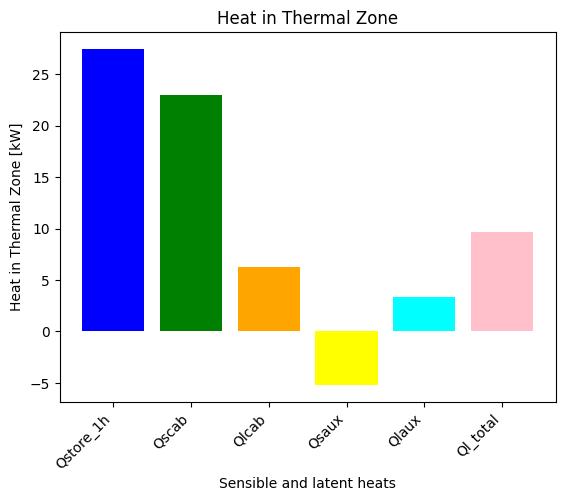

In [15]:
import matplotlib.pyplot as plt

# Given data in kW

Qstore_1h = 27.45445243726911
Qscab = 23.010006734482477
Qlcab = 6.282020907
Qsaux = -5.1975752042133685
Qlaux_value = 3.3600000000000003
Qlcab_value = 6.282020907
Ql_total = 9.642020907

# Calculate latent heat
Ql = Qlcab_value + Qlaux_value

# Plotting
labels = ['Qstore_1h', 'Qscab', 'Qlcab', 'Qsaux', 'Qlaux', 'Ql_total']

values = [Qstore_1h, Qscab, Qlcab, Qsaux, Qlaux_value, Ql_total]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'yellow', 'cyan', 'pink'])
plt.xlabel('Sensible and latent heats')
plt.ylabel('Heat in Thermal Zone [kW]')
plt.title('Heat in Thermal Zone')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

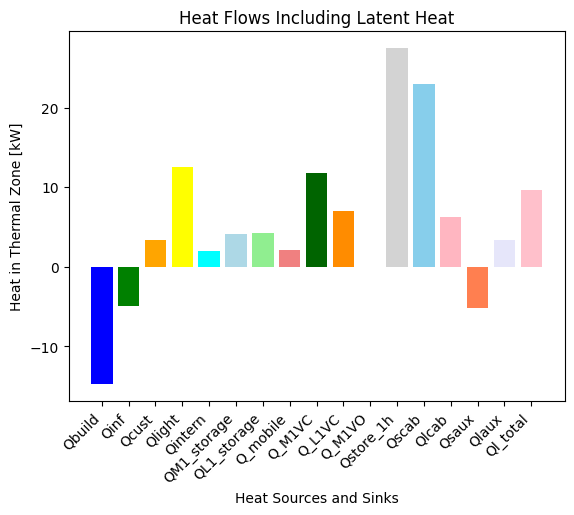

In [16]:
# Given data
Qbuild = -14.791736296296296
Qinf = -4.905838907917072
Qcust = 3.3600000000000003
Qlight = 12.5
Qintern = 2
QM1_storage = 4.080815094339623
QL1_storage = 4.271142857142857
Q_mobile_value = 2.148192059
Q_M1VC_value = 11.77539325
Q_L1VC_value = 7.016484381
Q_M1VO_value = 0
Qstore_1h = 27.45445243726911
Q_mobile = 2.148192059
Qscab = 23.010006734482477
Qlcab = 6.282020907
Qsaux = -5.1975752042133685
Qlaux_value = 3.3600000000000003
Qlcab_value = 6.282020907
Ql_total = 9.642020907

# Calculate latent heat
Ql = Qlcab_value + Qlaux_value

# Plotting
labels = ['Qbuild', 'Qinf', 'Qcust', 'Qlight', 'Qintern', 'QM1_storage', 'QL1_storage',
          'Q_mobile', 'Q_M1VC', 'Q_L1VC', 'Q_M1VO', 'Qstore_1h', 'Qscab', 'Qlcab', 'Qsaux', 'Qlaux', 'Ql_total']

values = [Qbuild, Qinf, Qcust, Qlight, Qintern, QM1_storage, QL1_storage,
          Q_mobile_value, Q_M1VC_value, Q_L1VC_value, Q_M1VO_value, Qstore_1h, Qscab, Qlcab, Qsaux, Qlaux_value, Ql_total]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'yellow', 'cyan', 'lightblue', 'lightgreen',
                               'lightcoral', 'darkgreen', 'darkorange', 'indianred', 'lightgrey', 'skyblue', 'lightpink', 'coral', 'lavender', 'pink'])
plt.xlabel('Heat Sources and Sinks')
plt.ylabel('Heat in Thermal Zone [kW]')
plt.title('Heat Flows Including Latent Heat')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()